# コンジョイント分析を用いて、消費者の好みを分析してみよう  
コンジョイント分析とは、いくつかの製品属性を組み合わせた複数の代替案を回答者に提示し、好ましさをランク付けしてもらい、回答者の選好を分析する手法です。コンジョイント分析を用いることで、製品の価格や色、デザイン、品質などの要因が、それぞれどのくらい選好に影響を与えているかを調べることができます（グロービス経営大学院の記事より引用）。  



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_csv('chap8_2_Data.csv')
# x, y の指定
y = pd.DataFrame(df['score'])
x = df.drop(columns=['score'])
x.head(10)

,price,timeToSta,isParking,direction
0,1,1,1,2
1,1,1,2,1
2,1,2,1,1
3,1,2,2,3
4,2,2,2,2
5,2,2,1,1
6,2,1,2,1
7,2,1,1,3


In [3]:
x_dum = pd.get_dummies(x, columns=x.columns, drop_first=True)
x_dum.head()

,price_2,timeToSta_2,isParking_2,direction_2,direction_3
0,0,0,0,1,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,1,1,0,1
4,1,1,1,1,0


In [4]:
df.describe()

,score,price,timeToSta,isParking,direction
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,5.262500,1.500000,1.500000,1.500000,1.750000
std,0.698851,0.534522,0.534522,0.534522,0.886405
min,4.300000,1.000000,1.000000,1.000000,1.000000
25%,4.750000,1.000000,1.000000,1.000000,1.000000
50%,5.200000,1.500000,1.500000,1.500000,1.500000
75%,5.775000,2.000000,2.000000,2.000000,2.250000
max,6.300000,2.000000,2.000000,2.000000,3.000000


In [5]:
x_dum=sm.add_constant(x_dum)
x_dum.head(10)

C:\Users\itaku\anaconda3\envs\py38_geopanda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,price_2,timeToSta_2,isParking_2,direction_2,direction_3
0,1.0,0,0,0,1,0
1,1.0,0,0,1,0,0
2,1.0,0,1,0,0,0
3,1.0,0,1,1,0,1
4,1.0,1,1,1,1,0
5,1.0,1,1,0,0,0
6,1.0,1,0,1,0,0
7,1.0,1,0,0,0,1


In [6]:
model = sm.OLS(y, x_dum)
result = model.fit()
result.summary()

C:\Users\itaku\anaconda3\envs\py38_geopanda\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     99.05
Date:                Sun, 02 Jan 2022   Prob (F-statistic):             0.0100
Time:                        13:28:50   Log-Likelihood:                 14.113
No. Observations:                   8   AIC:                            -16.23
Df Residuals:                       2   BIC:                            -15.75
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.3375      0.066     96.681      0.000       6.055       6.620
price_2        -1.0250      0.059    -17.482      0.003      -1.277      -0.773
timeToSta_2    -0.5750      0.059     -9.807      0.010      -0.827      -0.323
isParking_2    -0.0250      0.059     -0.426      0.711      -0.277       0.227
direction_2    -0.3750      0.072     -5.222      0.035      -0.684      -0.066
direction_3    -0.6750      0.072     -9.400      0.011      -0.984      -0.366
==============================================================================
Omnibus:                        1.236   Durbin-Watson:                   2.591
Prob(Omnibus):                  0.539   Jarque-Bera (JB):                0.627
Skew:                           0.000   Prob(JB):                        0.731
Kurtosis:                       1.628   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
df_res = pd.DataFrame({
    'name': result.params.keys()
    , 'weight': result.params.values
    , 'p_val': result.pvalues
})
df_res

,name,weight,p_val
const,const,6.3375,0.000107
price_2,price_2,-1.0250,0.003256
timeToSta_2,timeToSta_2,-0.5750,0.010238
isParking_2,isParking_2,-0.0250,0.711325
direction_2,direction_2,-0.3750,0.034766
direction_3,direction_3,-0.6750,0.011128


グラフ表示のため行追加

In [8]:
df_graph = df_res
df_graph = df_graph.sort_values('name')

前処理

In [9]:
df_graph['abs_weight'] = np.abs(df_graph['weight'])
df_graph['color'] = ["blue" if s < 0.05 else "red" for s in df_graph['p_val']] 
df_graph = df_graph.sort_values(by='abs_weight', ascending=True)

グラフ表示

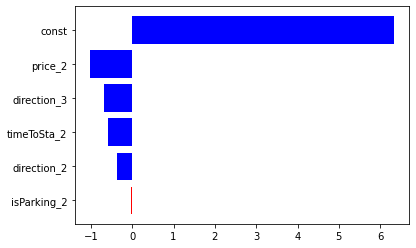

In [10]:
xbar = np.arange(len(df_graph['weight']))
plt.barh(xbar, df_graph['weight'], color=df_graph['color'])
plt.yticks(xbar, labels=df_graph['name'])
plt.show()

# 参考記事  
グロービス経営大学院:コンジョイント分析  
https://mba.globis.ac.jp/about_mba/glossary/detail-11804.html